In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_2_1'

In [2]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍
scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 389972464                 to 403799267                
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 20128990                  to 29538459                 
scope.clock.adc_rate                     changed from 20128990.0                to 29538459.0        

In [3]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6163 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6163 bytes


In [4]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

In [5]:
import ctypes
import time
import numpy as np
from tqdm.notebook import trange
from picosdk.ps2000a import ps2000a as ps
from picosdk.functions import adc2mV, assert_pico_ok

status = {}
# This flag will be flipped to stop streaming when the trigger is detected.
autoStopOuter = True

# Number of traces to capture
NUM_TRACES = 2500

# Number of samples per acquisition (adjust as needed)
NUM_SAMPLES = 5000

sample_interval = ctypes.c_int32(100)
sample_units = ps.PS2000A_TIME_UNITS['PS2000A_US']
timebase = 5
downsample_ratio = ctypes.c_uint32(1)  # no downsampling
ratio_mode = ps.PS2000A_RATIO_MODE['PS2000A_RATIO_MODE_NONE']

In [6]:
ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()

target.set_key(key)
print(key)

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


In [7]:
# Open the PicoScope unit
chandle = ctypes.c_int16()
status["openunit"] = ps.ps2000aOpenUnit(ctypes.byref(chandle), None)
assert_pico_ok(status["openunit"])
print("PicoScope opened successfully.")

#For converting ADC values to mV later on
maxADC = ctypes.c_int16()
status["maximumValue"] = ps.ps2000aMaximumValue(chandle, 
                                                ctypes.byref(maxADC))
assert_pico_ok(status["maximumValue"])
print(maxADC)

PicoScope opened successfully.
c_short(32512)


In [8]:
# Set up Channel A for the AC-coupled 50 mV probe
status["setChA"] = ps.ps2000aSetChannel(chandle,
                                        ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A'],
                                        1,  # enabled
                                        ps.PS2000A_COUPLING['PS2000A_AC'],  # AC coupling
                                        ps.PS2000A_RANGE['PS2000A_50MV'],  # 50 mV range
                                        0)  # no offset
assert_pico_ok(status["setChA"])
print("Channel A configured: AC, 50 mV range.")

# Set up Channel B to be used as trigger at 2 V
status["setChB"] = ps.ps2000aSetChannel(chandle,
                                        ps.PS2000A_CHANNEL['PS2000A_CHANNEL_B'],
                                        1,  # enabled
                                        ps.PS2000A_COUPLING['PS2000A_DC'],
                                        ps.PS2000A_RANGE['PS2000A_2V'],  # 2 V range
                                        0)
assert_pico_ok(status["setChB"])
print("Channel B configured: DC, 2 V range for triggering.")


# Set up a simple trigger on Channel B.
status["trigger"] = ps.ps2000aSetSimpleTrigger(chandle,
                                                1,  # enable trigger
                                                ps.PS2000A_CHANNEL['PS2000A_CHANNEL_B'],  # trigger source: Channel B
                                                ctypes.c_int16(29260),  # threshold in adc
                                                ps.PS2000A_THRESHOLD_DIRECTION['PS2000A_RISING'],  # trigger on rising edge
                                                0,  # no delay
                                                0)  
assert_pico_ok(status["trigger"])
print("Trigger configured on Channel B (threshold 1.8 V, rising edge).")

# Allocate a buffer for Channel A
bufferA = np.zeros(NUM_SAMPLES, dtype=np.int16)
memory_segment = 0
# Register the data buffer with the PicoScope
status["setDataBufferA"] = ps.ps2000aSetDataBuffer(chandle,
                                                    ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A'],
                                                    bufferA.ctypes.data_as(ctypes.POINTER(ctypes.c_int16)),
                                                    NUM_SAMPLES,
                                                    memory_segment,
                                                    ratio_mode)
assert_pico_ok(status["setDataBufferA"])
    
print("Data buffer for Channel A allocated ({} samples).".format(NUM_SAMPLES))



# Prepare list to collect acquired traces
traces_array = []

print("Beginning capture loop ({} acquisitions)...".format(NUM_TRACES))
for trace_num in trange(NUM_TRACES):
    traces_list = np.array([])
    collected_samples = ctypes.c_uint32(NUM_SAMPLES)
    throwaway = ctypes.c_int16(0)
    block_ready = ctypes.c_int16(0)
    bufferA[:] = 0
    status["runBlock"] = ps.ps2000aRunBlock(chandle,
                                            0, # pre trigger samples
                                            NUM_SAMPLES, # post trigger samples
                                            timebase,
                                            0,
                                            None,
                                            memory_segment,
                                            None,
                                            None)
                                            
    assert_pico_ok(status["runBlock"])
    target.simpleserial_write('p', text)
   
    while block_ready.value == 0:
        status["blockReady"] = ps.ps2000aIsReady(chandle,
                                             ctypes.byref(block_ready))
        time.sleep(0.01)
    response = target.simpleserial_read('r', 16)
    textin_array.append(text)
    status["getValues"] = ps.ps2000aGetValues(chandle, 
                                              0,
                                              ctypes.byref(collected_samples), 
                                              downsample_ratio, 
                                              ratio_mode, 
                                              memory_segment, 
                                              ctypes.byref(throwaway))
    assert_pico_ok(status["getValues"])
    traces_array.append(bufferA.copy())
    
    key, text = ktp.next() 


status["stop"] = ps.ps2000aStop(chandle)
assert_pico_ok(status["stop"])

traces_pico = np.array(traces_array) / 100
print("Capture complete. Data shape: ", traces_pico.shape)

Channel A configured: AC, 50 mV range.
Channel B configured: DC, 2 V range for triggering.
Trigger configured on Channel B (threshold 1.8 V, rising edge).
Data buffer for Channel A allocated (5000 samples).
Beginning capture loop (2500 acquisitions)...


  0%|          | 0/2500 [00:00<?, ?it/s]

Capture complete. Data shape:  (2500, 5000)


In [9]:
scope.dis()
target.dis()
# Close the PicoScope device.
status["close"] = ps.ps2000aCloseUnit(chandle)
assert_pico_ok(status["close"])

#traces_pico = traces_pico[7:, :]
#textin_array = textin_array[7:]
#NUM_TRACES = NUM_TRACES - 8

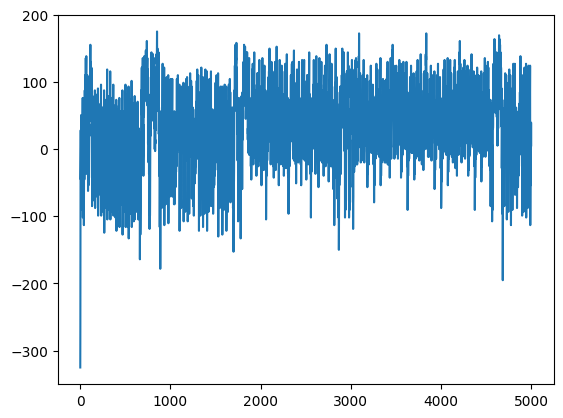

In [10]:
import matplotlib.pyplot as plt

plt.plot(traces_pico[11])
plt.show()

In [11]:
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

In [12]:
maxcpa = [0] * 256
HW = [bin(n).count("1") for n in range(0, 256)]
# we don't need to redo the mean and std dev calculations 
# for each key guess
t_bar = mean(traces_pico) 
o_t = std_dev(traces_pico, t_bar)

for kguess in trange(0, 256):
    hws = np.array([[HW[aes_internal(textin[0],kguess)] for textin in textin_array]]).transpose()
    
    # ###################
    # Add your code here
    # ###################
    #raise NotImplementedError("Add your code here, and delete this.")
    
    # ###################
    # START SOLUTION
    # ###################
    hws_bar = mean(hws)
    o_hws = std_dev(hws, hws_bar)
    correlation = cov(traces_pico, t_bar, hws, hws_bar)
    cpaoutput = correlation/(o_t*o_hws)
    maxcpa[kguess] = max(abs(cpaoutput))
    

guess = np.argmax(maxcpa)
guess_corr = max(maxcpa)
# ###################
# END SOLUTION
# ###################
print("Key guess: ", hex(guess))
print("Correlation: ", guess_corr)

  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  0x2b
Correlation:  0.18645799022533074


In [13]:
t_bar = np.sum(traces_pico, axis=0)/len(traces_pico)
o_t = np.sqrt(np.sum((traces_pico - t_bar)**2, axis=0))

cparefs = [0] * 16 #put your key byte guess correlations here
bestguess = [0] * 16 #put your key byte guesses here

for bnum in trange(0, 16):
    maxcpa = [0] * 256
    for kguess in range(0, 256):
    # ###################
    # Add your code here
    # ###################
    #raise NotImplementedError("Add your code here, and delete this.")
    
    # ###################
    # START SOLUTION
    # ###################
        hws = np.array([[HW[aes_internal(textin[bnum],kguess)] for textin in textin_array]]).transpose()
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(traces_pico, t_bar, hws, hws_bar)
        cpaoutput = correlation/(o_t*o_hws)
        maxcpa[kguess] = max(abs(cpaoutput))
    bestguess[bnum] = np.argmax(maxcpa)
    cparefs[bnum] = max(maxcpa)
    # ###################
    # END SOLUTION
    # ###################

print("Best Key Guess: ", end="")
for b in bestguess: print("%02x " % b, end="")
print("\n", cparefs)

  0%|          | 0/16 [00:00<?, ?it/s]

Best Key Guess: 2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c 
 [0.18645799022533074, 0.1732338780495584, 0.2134221111644228, 0.2341049648964049, 0.1654633931770579, 0.2265889909957589, 0.19097626978555451, 0.18605961386877504, 0.20279924370888117, 0.2203473981961955, 0.19044646620422254, 0.19321398229202907, 0.20162667087904684, 0.2075232403617413, 0.20441596177662785, 0.17896466415303572]


In [ ]:
#2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c